# Feature performance comparison

The purpose of this notebook is to compare the classification performance of the individual features, and their combination, for A. Thaliana

# Imports

In [1]:
from subpred.transporter_dataset import create_dataset
from subpred.compositions import calculate_paac, calculate_aac
from subpred.eval import (
    get_independent_test_set,
    optimize_hyperparams,
    preprocess_pandas,
    models_quick_compare,
    get_confusion_matrix,
    get_classification_report,
    full_test,
    quick_test
)
from subpred.util import get_feature_score
from subpred.plots import labeled_clustermap, pca_plot_2d, pca_plot_3d
from subpred.pssm import calculate_pssms_notebook

import pandas as pd


# Dataset

In [2]:
df = create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Membrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="remove",
    outliers=["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"],
    verbose=True,
    tax_ids_filter=[3702],
    output_log="../logs/athaliana_sugar_amino.log",
    sequence_clustering=70
)

cd-hit: clustered 165 sequences into 117 clusters at threshold 70


# Feature generation

In [3]:
labels = df.keywords_transport
labels.value_counts()

Sugar transport         84
Amino-acid transport    33
Name: keywords_transport, dtype: int64

In [4]:
df_aac = calculate_aac(df.sequence)
df_paac = calculate_paac(df.sequence)
df_pssm = calculate_pssms_notebook(df.sequence)

In [5]:
df_combined = pd.concat([
    df_aac, df_paac, df_pssm
], axis=1)
df_combined

,A,C,D,E,F,G,H,I,K,L,...,VL_90_3,VK_90_3,VM_90_3,VF_90_3,VP_90_3,VS_90_3,VT_90_3,VW_90_3,VY_90_3,VV_90_3
Uniprot,,,,,,,,,,,,,,,,,,,,,
Q9SFG0,0.090730,0.015779,0.033531,0.035503,0.086785,0.088757,0.015779,0.092702,0.033531,0.104536,...,0.434307,0.381387,0.421533,0.578467,0.357664,0.390511,0.392336,0.512774,0.656934,0.417883
Q84WN3,0.066390,0.004149,0.020747,0.053942,0.070539,0.074689,0.008299,0.070539,0.041494,0.120332,...,0.383260,0.264317,0.374449,0.726872,0.215859,0.286344,0.312775,0.493392,0.982379,0.352423
O04249,0.079922,0.013645,0.017544,0.042885,0.066277,0.107212,0.011696,0.076023,0.035088,0.120858,...,0.476898,0.415842,0.471947,0.592409,0.387789,0.415842,0.422442,0.514851,0.702970,0.450495
Q56ZZ7,0.128205,0.009158,0.020147,0.038462,0.051282,0.106227,0.003663,0.058608,0.031136,0.120879,...,0.488636,0.433442,0.472403,0.608766,0.420455,0.461039,0.462662,0.514610,0.657468,0.470779
Q8H184,0.065217,0.012077,0.045894,0.057971,0.084541,0.062802,0.009662,0.050725,0.050725,0.111111,...,0.486772,0.391534,0.473545,0.595238,0.370370,0.417989,0.431217,0.505291,0.679894,0.473545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q94B65,0.095975,0.009288,0.015480,0.027864,0.055728,0.077399,0.012384,0.068111,0.055728,0.148607,...,0.542056,0.489097,0.529595,0.716511,0.426791,0.523364,0.504673,0.613707,0.894081,0.520249
Q0WWW9,0.082437,0.010753,0.028674,0.037634,0.066308,0.114695,0.007168,0.060932,0.039427,0.154122,...,0.544582,0.465021,0.515775,0.632373,0.455418,0.486968,0.482853,0.539095,0.703704,0.514403
Q2V4B9,0.092929,0.020202,0.024242,0.038384,0.062626,0.105051,0.008081,0.050505,0.036364,0.137374,...,0.521151,0.495770,0.510998,0.566836,0.477157,0.502538,0.502538,0.509306,0.602369,0.500846


## Plots

First, let's create a plot of the three feature types, and see how they look together in a dataframe:

({'aac': 'cyan', 'paac': 'magenta', 'pssm': 'yellow'},
 <seaborn.matrix.ClusterGrid at 0x7f885901c040>)

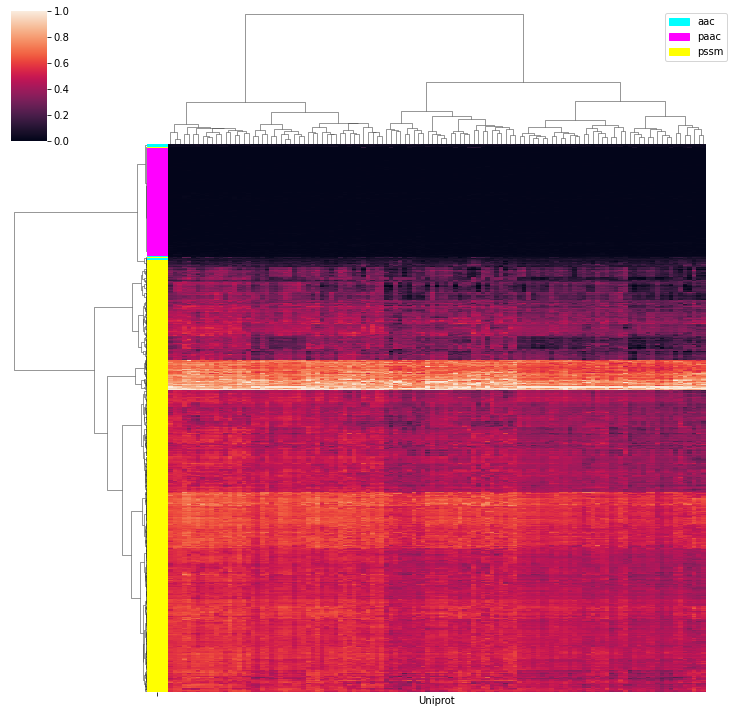

In [6]:
import re

aac = re.compile(r"^[ACDEFGHIKLMNPQRSTVWY]$")
paac = re.compile(r"^[ACDEFGHIKLMNPQRSTVWY][ACDEFGHIKLMNPQRSTVWY]$")
pssm = re.compile(r"^[ACDEFGHIKLMNPQRSTVWY][ACDEFGHIKLMNPQRSTVWY]_\d\d_\d$")

def get_feature_type(feature_name):
    if paac.match(feature_name):
        return "paac"
    elif aac.match(feature_name):
        return "aac"
    elif pssm.match(feature_name):
        return "pssm"
    else:
        raise ValueError("unknown feature type!")

labeled_clustermap(df_combined.T, df_combined.columns.to_series().apply(get_feature_type))

PAAC and AAC values are a lot lower, since they are percentages, while PSSM values are scaled to [0,1]. The scaling was done along the feature axis, to avoid information sharing. What does the data look like when we also scale PAAC and AAC to [0,1]?

({'aac': 'cyan', 'paac': 'magenta', 'pssm': 'yellow'},
 <seaborn.matrix.ClusterGrid at 0x7f88467d9a60>)

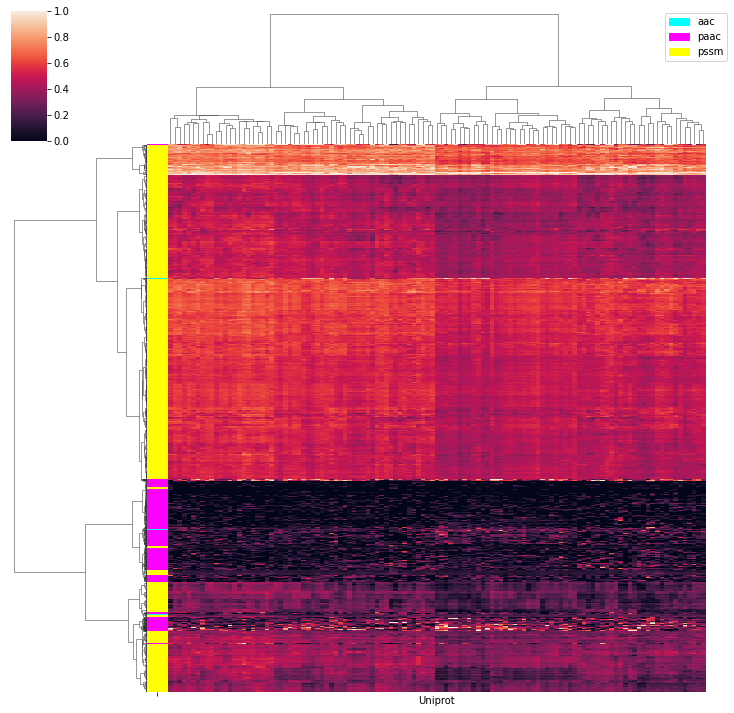

In [7]:
from sklearn.preprocessing import minmax_scale

def min_max_samples(df_feature):
    return pd.DataFrame(data=minmax_scale(df_feature, axis=1), index=df_feature.index, columns = df_feature.columns)

df_combined_minmax = pd.concat([
    min_max_samples(df_aac), min_max_samples(df_paac), min_max_samples(df_pssm)
], axis=1)
# df_combined_minmax = pd.DataFrame(data=minmax_scale(df_combined, axis=1), index=df_combined.index, columns = df_combined.columns)
labeled_clustermap(df_combined_minmax.T, df_combined_minmax.columns.to_series().apply(get_feature_type))
# df_combined_minmax#.iloc[0].max()

PAAC feature has more low values than PSSM, since many dipeptides simply do not exist in the sequences. They are still mostly distinguishable. AAC mixes with PAAC. Scaling AAC and PAAC now should not make a difference, since they are standardized later anyway. 

What does the data look like when standardizing along the feature axis? In the model, the parameters for this will be derived from the training set and applied to the test set, to avoid data leakage.

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f885c063c10>)

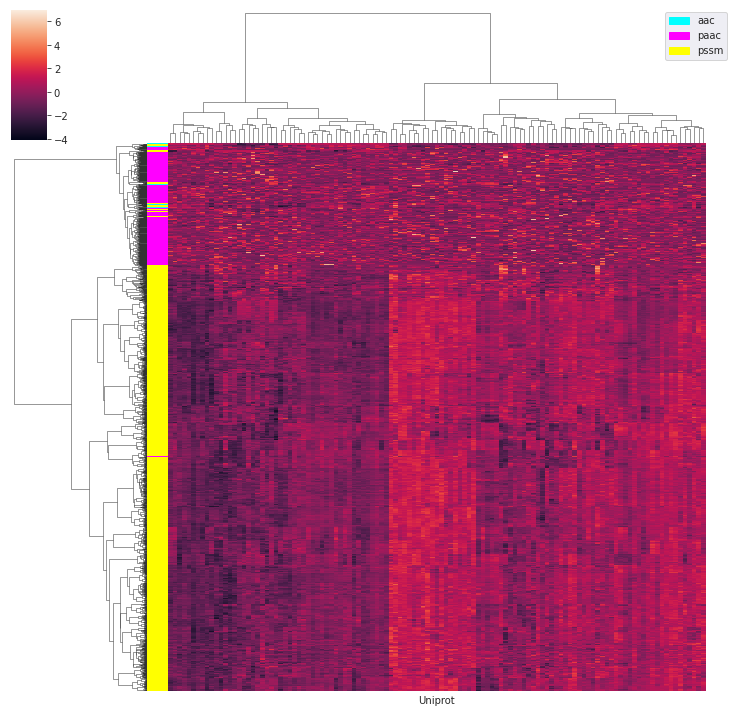

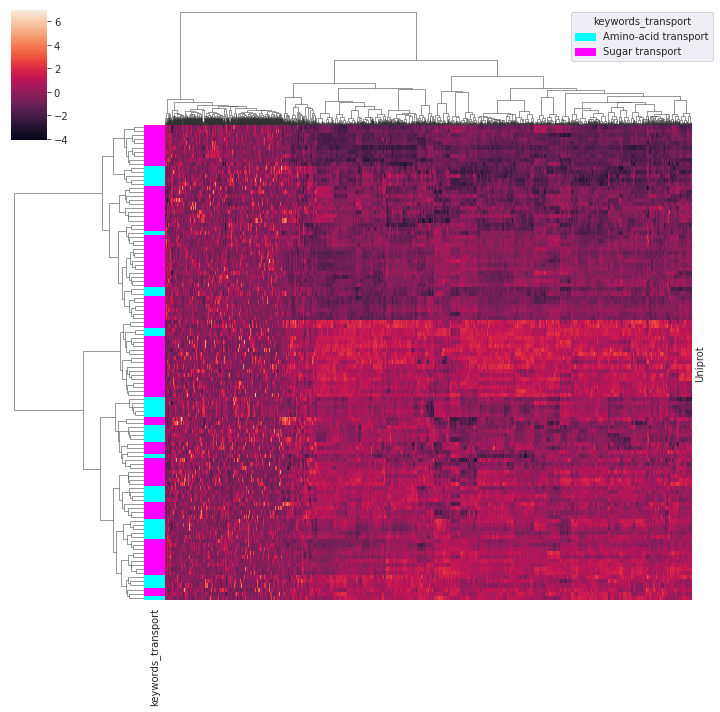

In [11]:
from sklearn.preprocessing import scale

df_combined_std = pd.DataFrame(
    data=scale(df_combined), index=df_combined.index, columns=df_combined.columns
)
labeled_clustermap(
    df_combined_std.T, df_combined.columns.to_series().apply(get_feature_type)
)
labeled_clustermap(
    df_combined_std, df.keywords_transport
)
# df_combined_std = None

The composition data looks a bit noisier, however this could also be caused by the fact that more PSSM features exist, and therefore have a higher impact on the h-clustering algorithm. The second plot shows that the two sample clusters do not correspond to the classes. 

### PCA Plots

After scaling the AAC and PAAC features to \[0,1\], the differences become quite clear. They should compliment each other well, since they do not share a considerable amount of overlap.

#### PCA after scaling AAC and PAAC to 0,1

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

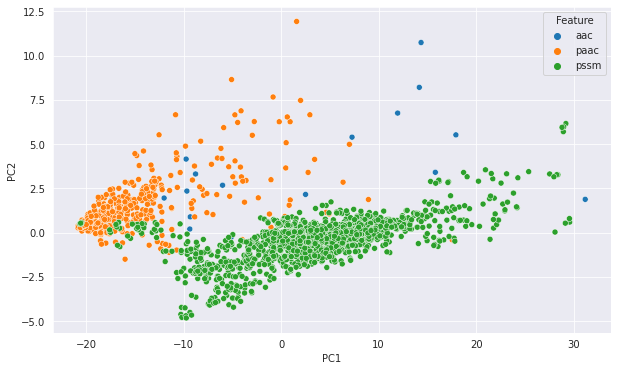

In [9]:
pca_plot_2d(df_combined_minmax.T, df_combined_minmax.T.index.to_series().apply(get_feature_type).rename("Feature"))

#### PCA after standardizing the whole dataset

This is roughly the data that the model will be trained on, results look similar to scaling in that pssm and paac are clearly separated.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

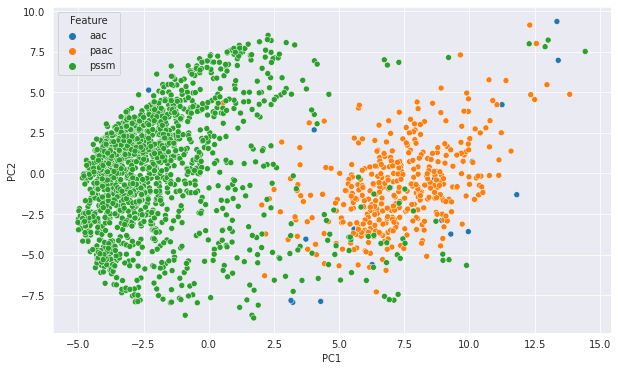

In [12]:
pca_plot_2d(df_combined_std.T, df_combined_std.T.index.to_series().apply(get_feature_type).rename("Feature"))

## Independent test set

In [15]:
X, y, feature_names, sample_names = preprocess_pandas(
    df_combined, labels, return_names=True
)
(
    X_train,
    X_test,
    y_train,
    y_test,
    sample_names_train,
    sample_names_test,
) = get_independent_test_set(X, y, sample_names=sample_names, test_size=0.2)



## Model comparison

In [16]:
models_quick_compare(X_train, y_train)

,0,1,2,3,4,mean,std
est,,,,,,,
GaussianNB(),0.729,0.842,0.878,0.778,0.557,0.757,0.126
KNeighborsClassifier(),0.808,0.683,0.878,0.926,0.734,0.806,0.100
"LinearSVC(class_weight='balanced', max_iter=1000000.0)",0.878,1.000,0.942,0.935,0.819,0.915,0.069
LinearSVC(max_iter=1000000.0),0.878,1.000,0.942,0.935,0.819,0.915,0.069
RandomForestClassifier(),0.683,0.864,1.000,0.839,0.926,0.863,0.118
RandomForestClassifier(class_weight='balanced'),0.737,0.737,1.000,0.839,0.734,0.810,0.115
SGDClassifier(),0.878,0.774,0.942,0.875,0.714,0.837,0.091
SVC(),0.737,0.737,0.936,1.000,0.734,0.829,0.129
SVC(class_weight='balanced'),1.000,0.927,1.000,1.000,0.926,0.971,0.040


## Investigation of the dataset

The SVC results are again surprisingly good, let's look at the data:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

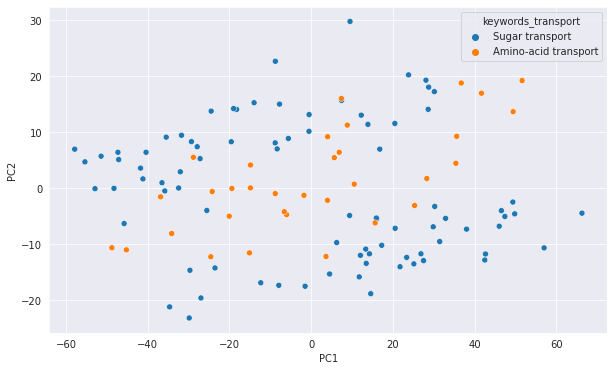

In [11]:

pca_plot_2d(df_combined, labels)
# pca_plot_3d(df_pssm, labels)

### Feature importance

In [12]:
top50 = get_feature_score(df_combined, labels).sort_values(
    "Normalized score", ascending=False
).head(50)
top50.Feature.apply(get_feature_type).value_counts()

pssm    43
paac     6
aac      1
Name: Feature, dtype: int64

Most of the best-performing features come from PSSMs, but there are also some paac, and aac features in the top 50.

In [13]:
top50[top50.Feature.apply(get_feature_type) == "aac"]

,Feature,Normalized score,Measure
8,K,0.003131,Feature importance (f_classif)


The AA Lysine appears again here are as the most important AAC feature when comparing sugar and amino acid transporters

In [14]:
top50[top50.Feature.apply(get_feature_type) == "paac"]

,Feature,Normalized score,Measure
59,CY,0.007527,Feature importance (f_classif)
109,FL,0.003577,Feature importance (f_classif)
122,GD,0.003336,Feature importance (f_classif)
213,LQ,0.003181,Feature importance (f_classif)
212,LP,0.003145,Feature importance (f_classif)
359,TY,0.002770,Feature importance (f_classif)


Interestingly, the dipeptide Cysteine-Thyrosine appears here as the most important feature. It could be the case that Thyrosine is more reactive with a longer side chain, and leads to some sort of selection?

There also are four dipeptides containing Leucine, a hydrophobic amino acid found in transmembrane helices.  

In [15]:
top50[top50.Feature.apply(get_feature_type) == "pssm"].head(10)

,Feature,Normalized score,Measure
988,HH_50_3,0.009791,Feature importance (f_classif)
984,HC_50_3,0.007620,Feature importance (f_classif)
998,HY_50_3,0.006974,Feature importance (f_classif)
997,HW_50_3,0.006668,Feature importance (f_classif)
844,RC_50_3,0.005498,Feature importance (f_classif)
1144,TC_50_3,0.005383,Feature importance (f_classif)
1009,II_50_3,0.005113,Feature importance (f_classif)
1169,WI_50_3,0.005017,Feature importance (f_classif)
993,HF_50_3,0.004987,Feature importance (f_classif)
989,HI_50_3,0.004723,Feature importance (f_classif)


Cysteine and Thyrosine are also among the top PSSM features. Overall, it seems like PSSM and AAC/PAAC do not share exactly the same information, but compliment each other well instead.

In [16]:
top50[top50.Feature.apply(get_feature_type) == "pssm"].Feature.apply(lambda x: [x[0], x[1]]).explode().value_counts()

H    22
C     8
I     7
F     6
P     5
D     5
W     5
M     4
Y     4
A     4
N     3
G     3
T     2
R     2
K     2
E     2
V     1
S     1
Name: Feature, dtype: int64

## Parameter tuning

#### Custom transformer


Whole dataset, linear svm

In [17]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="linear",
    dim_reduction=None,
    C=[10, 100, 1000],
)
best_estimator_svc = gsearch


{'linearsvc__C': 100, 'linearsvc__class_weight': None, 'linearsvc__dual': False, 'linearsvc__max_iter': 100000000.0}
0.938


Good results, but relatively high value for C. With the custom transformer:

In [18]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="linear",
    dim_reduction=None,
    C=[10, 100, 1000],
    # C=[1, 10, 100],
    feature_transformer="pssm",
    feature_names=feature_names,
)
best_estimator_svc = gsearch


{'linearsvc__C': 100, 'linearsvc__class_weight': None, 'linearsvc__dual': False, 'linearsvc__max_iter': 100000000.0, 'pssmselector__iterations': 3, 'pssmselector__uniref_threshold': 'all'}
0.987


Same results as before. Maybe RBF allows for a lower value of C?

In [19]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction=None,
    C=[0.1, 1, 10],
)
best_estimator_svc = gsearch

{'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.971


This performs a bit below the PSSM feature. SVM parameters are good now. What about the transformer?

In [20]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction=None,
    C=[0.1, 1, 10],
    feature_transformer="pssm",
    feature_names=feature_names,
)
best_estimator_svc = gsearch

{'pssmselector__iterations': 'all', 'pssmselector__uniref_threshold': 'all', 'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.971


In this case, the transformer does not change anything.

## Dimensionality reduction

Trying only in steps of 20, to reduce runtime. With the linear kernel, we get the high C again:

In [21]:
gsearch = optimize_hyperparams(
    X_train, y_train, kernel="linear", dim_reduction="kbest", C=[10, 100, 1000], select_k_steps=20
)
best_estimator_svc_kbest = gsearch

{'linearsvc__C': 100, 'linearsvc__class_weight': None, 'linearsvc__dual': False, 'linearsvc__max_iter': 100000000.0, 'selectkbest__k': 1181}
0.974


In [22]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="linear",
    dim_reduction="pca",
    # feature_transformer="pssm",
    # feature_names=feature_names,
    # C=[0.1, 0.01, 0.001],
    # gamma=[0.1, 0.01, 0.001],
)


{'linearsvc__C': 0.1, 'linearsvc__class_weight': None, 'linearsvc__dual': True, 'linearsvc__max_iter': 100000000.0, 'pca__n_components': 0.99}
0.985


PCA seems to perform the best and is faster, how about the RBF kernel?

In [23]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction="pca",
    # feature_transformer="pssm",
    # feature_names=feature_names,
    C=[1, 10,100],
    gamma=["scale", 0.1, 0.01, 0.001],
)
best_estimator_svc_pca = gsearch

{'pca__n_components': 0.89, 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 0.001}
0.987


This time, the PSSM transformer does not make a difference, and we get the same score:

In [24]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction="pca",
    feature_transformer="pssm",
    feature_names=feature_names,
    C=[1, 0.1, 10],
    gamma=["scale", 0.1, 0.01, 0.001],
)
best_estimator_svc_pca = gsearch

{'pca__n_components': 0.8300000000000001, 'pssmselector__iterations': 3, 'pssmselector__uniref_threshold': 50, 'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.987


## Validation

The validations set still returns perfect scores, for both PCA and Kbest:

### Kbest

In [25]:
get_confusion_matrix(X_test, y_test, best_estimator_svc_kbest, labels=labels)

predicted,Amino-acid transport,Sugar transport
observed,,
Amino-acid transport,7,0
Sugar transport,0,17


In [26]:
get_classification_report(X_test, y_test, best_estimator_svc_kbest, labels=labels)

,precision,recall,f1-score,support
Amino-acid transport,1.0,1.0,1.0,7
Sugar transport,1.0,1.0,1.0,17
macro avg,1.0,1.0,1.0,24
weighted avg,1.0,1.0,1.0,24


### PCA

In [27]:
get_confusion_matrix(X_test, y_test, best_estimator_svc_pca, labels=labels)

predicted,Amino-acid transport,Sugar transport
observed,,
Amino-acid transport,7,0
Sugar transport,0,17


In [28]:
get_classification_report(X_test, y_test, best_estimator_svc_pca, labels=labels)

,precision,recall,f1-score,support
Amino-acid transport,1.0,1.0,1.0,7
Sugar transport,1.0,1.0,1.0,17
macro avg,1.0,1.0,1.0,24
weighted avg,1.0,1.0,1.0,24


## Estimating validation variance

How much did the result depend on choosing the training and test sets?

Mean and standard deviation for randomly selected training and validation sets.

In [29]:
df_scores, df_params = full_test(
    df_combined,
    labels,
    dim_reduction="pca",
    kernel="rbf",
    repetitions=10,
    feature_transformer="pssm",
)
df_scores_gr = df_scores.groupby(["label", "dataset"], as_index=False)
print("Mean F1")
display(df_scores_gr.mean().pivot(index="label", columns="dataset", values="F1 score"))
print("Sdev F1")
display(df_scores_gr.std().pivot(index="label", columns="dataset", values="F1 score"))
print("Parameters")
display(df_params)

Mean F1


dataset,test,train
label,,
Amino-acid transport,0.9354,0.9902
Sugar transport,0.9734,0.9963


Sdev F1


dataset,test,train
label,,
Amino-acid transport,0.064238,0.010337
Sugar transport,0.025877,0.003917


Parameters


,0,1,2,3,4,5,6,7,8,9
pca__n_components,0.85,0.88,0.93,0.80,0.8,0.8,0.82,0.81,0.8,0.8
pssmselector__iterations,all,all,all,3.00,3,all,3,3,all,all
pssmselector__uniref_threshold,50,all,all,50.00,all,50,50,all,50,50
svc__C,10,10,10,10.00,1,1,1,1,1,10
svc__class_weight,balanced,balanced,balanced,NaN,balanced,balanced,balanced,None,None,balanced
svc__gamma,0.01,scale,0.01,0.01,scale,0.1,scale,scale,scale,scale


As expected, amino acid has higher variance due to the lower sample count. Other than that, the models seem stable.